### **Lab7.ipynb**

#### Activity
- Data science - Laboratorio 7

#### Authors:
- Diego Lemus
- Fabián Juárez


#### Date:
- 22 de Septiembre 2024


#### Repository:
- Link: https://github.com/FabianJuarez182/DS-LAB7.git

### Task 2 y 3

In [1]:
import json
import pandas as pd
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Descargar las stopwords en español de nltk
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

# Cargar el archivo .txt con manejo de errores para JSON
def load_json_txt(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-16') as file:  # Cambiamos a utf-16
        for line in file:
            line = line.strip()  # Eliminar espacios en blanco y saltos de línea
            if line:  # Verificar que la línea no esté vacía
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError:
                    continue  # Ignorar líneas mal formadas
    return pd.DataFrame(data)

# Función para limpiar el texto
def clean_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Eliminar caracteres especiales, menciones y números
    text = re.sub(r'\@\w+|\#|\d+', '', text)
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Eliminar stopwords en español
    text = ' '.join([word for word in text.split() if word not in spanish_stopwords])
    return text

# Cargar el archivo de texto
df = load_json_txt('tioberny.txt')

# Aplicar la función de limpieza a la columna de texto
df['cleaned_text'] = df['rawContent'].apply(clean_text)

# Visualizar los datos limpiados
print(df[['rawContent', 'cleaned_text']].head())

# Calcular la frecuencia de las palabras
word_freq = Counter(" ".join(df['cleaned_text']).split())

# Mostrar las palabras más frecuentes después de la limpieza
print(word_freq.most_common(10))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                          rawContent  \
0  _\nConfirmado Compañeres,\n\nEl impuesto por l...   
1  #URGENTE Lo que los medios #faferos no informa...   
2  @IvanDuque @BArevalodeLeon Con que usaste PEGA...   
3  @IvanDuque @BArevalodeLeon Entre Ellos se enti...   
4  El presidente @BArevalodeLeon y la vicepreside...   

                                        cleaned_text  
0  confirmado compañeres impuesto —solo cuenta pa...  
1  urgente medios faferos informaron ayer acerca ...  
2  usaste pegasus espiar detractores obra narcisi...  
3         entienden bien cuadrando productivareunión  
4  presidente vicepresidenta participan sesión so...  
[('si', 462), ('presidente', 430), ('gobierno', 334), ('solo', 287), ('guatemala', 245), ('vos', 197), ('ser', 185), ('q', 181), ('corruptos', 177), ('bien', 171)]


Descripción de forma detallada las actividades de preprocesamiento que llevó a cabo:

1. **Cargar el archivo CSV**:
   - Se carga el archivo CSV que contiene los datos de los tweets en un DataFrame de pandas.

2. **Función para limpiar el texto**:
  
   - **Convertir a minúsculas**: 
     Convierte todo el texto a minúsculas para asegurar la uniformidad y evitar diferencias entre palabras como "Desastre" y "desastre".

   - **Eliminar URLs**:
     Elimina cualquier URL presente en el texto, ya que estas no aportan valor al análisis de contenido.

   - **Eliminar caracteres especiales y signos de puntuación**:
     Elimina menciones, hashtags, números y signos de puntuación para limpiar el texto y enfocarse en las palabras relevantes.

   - **Eliminar stopwords**:
     Elimina palabras comunes (stopwords) que no aportan mucho significado, como "the", "and", "is", etc., utilizando una lista predefinida de stopwords en inglés.

3. **Aplicar la función de limpieza a la columna de texto**:
   - Aplica la función `clean_text` a cada tweet en la columna 'text' y guarda el resultado en una nueva columna 'cleaned_text'.

4. **Separar en tweets de desastres y no desastres**:
   - Divide los tweets en dos grupos: aquellos que son sobre desastres (`target` == 1) y aquellos que no lo son (`target` == 0).

5. **Calcular la frecuencia de las palabras**:
   - Cuenta la frecuencia de cada palabra en los tweets de desastres y no desastres utilizando la clase `Counter` de la biblioteca `collections`.

In [2]:
import networkx as nx

# Función ajustada para extraer respuestas, menciones y retweets
def extract_interactions(row):
    interactions = []

    # Validar que 'user' y 'username' existan y sean cadenas
    if 'user' in row and isinstance(row['user'], dict) and 'username' in row['user']:
        user = row['user']['username'].lower() if isinstance(row['user']['username'], str) else None
    else:
        user = None

    # Extraer respuestas (si existen y son válidas)
    if 'inReplyToUser' in row and isinstance(row['inReplyToUser'], dict):
        replied_to_user = row['inReplyToUser'].get('username', None)
        if user and replied_to_user:
            interactions.append(('reply', user, replied_to_user.lower()))

    # Extraer menciones (si existen y son válidas)
    if 'mentionedUsers' in row and isinstance(row['mentionedUsers'], list):
        for mention in row['mentionedUsers']:
            if 'username' in mention and isinstance(mention['username'], str):
                interactions.append(('mention', user, mention['username'].lower()))

    # Extraer retweets (si existen y son válidos)
    if 'retweetedTweet' in row and isinstance(row['retweetedTweet'], dict):
        retweeted_user = row['retweetedTweet'].get('user', {}).get('username')
        if user and retweeted_user:
            interactions.append(('retweet', user, retweeted_user.lower()))

    return interactions

# Aplicar la extracción de interacciones a cada tweet
df['interactions'] = df.apply(extract_interactions, axis=1)

# Descomponer las interacciones en un DataFrame
interactions = []
for interaction_list in df['interactions']:
    interactions.extend(interaction_list)

# Crear un DataFrame con las interacciones
interaction_df = pd.DataFrame(interactions, columns=['type', 'source', 'target'])

# Eliminar duplicados
interaction_df = interaction_df.drop_duplicates()

# Contar el número de menciones, respuestas y retweets
interaction_counts = interaction_df['type'].value_counts()

# Mostrar cuántas interacciones de cada tipo existen
print("Conteo de interacciones por tipo:")
print(interaction_counts)

# Función para crear y exportar un grafo para cada tipo de interacción
def create_and_export_graph(interaction_type, interaction_df):
    # Filtrar las interacciones por el tipo deseado (mención, respuesta o retweet)
    filtered_df = interaction_df[interaction_df['type'] == interaction_type]

    # Verificar si hay interacciones para este tipo
    if filtered_df.empty:
        print(f"No se encontraron interacciones de tipo {interaction_type}")
        return

    # Crear un grafo dirigido
    G = nx.DiGraph()

    # Añadir las interacciones filtradas al grafo
    for index, row in filtered_df.iterrows():
        G.add_edge(row['source'], row['target'], interaction_type=row['type'])

    # Exportar el grafo a Gephi en formato GEXF
    file_name = f"user_interactions_graph_{interaction_type}.gexf"
    nx.write_gexf(G, file_name)
    print(f"Grafo de {interaction_type} exportado a Gephi como '{file_name}'")

# Crear y exportar grafos para menciones, respuestas y retweets
create_and_export_graph('mention', interaction_df)
create_and_export_graph('reply', interaction_df)
create_and_export_graph('retweet', interaction_df)

Conteo de interacciones por tipo:
type
mention    12246
reply       3872
Name: count, dtype: int64
Grafo de mention exportado a Gephi como 'user_interactions_graph_mention.gexf'
Grafo de reply exportado a Gephi como 'user_interactions_graph_reply.gexf'
No se encontraron interacciones de tipo retweet


Se evidencia que no existen los retweet de manera explicita por lo que se utilizará la cnatidad de retweets de cada tweet para visualizar que tanto auge tienen y que tan influyente es el usuario.

### Task 4

Número total de tweets: 5019
Número de usuarios únicos: 2620
Número total de menciones: 12246
Número total de respuestas: 3872
Hashtags más frecuentes:
URGENTE: 25
GuatemalaSaleAdelante: 24
MinfinSaleAdelante: 17
Guatemala: 15
Presupuesto2025: 14
UnPresupuestoParaLaPoblación: 13
EnElPaísDCA: 12
NacionalesAGN: 8
XelaNews: 7
ElEstor: 7


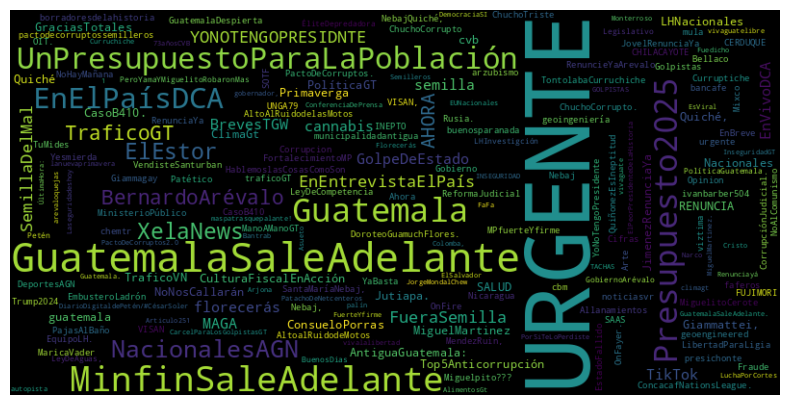

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Número total de tweets
num_tweets = len(df)
print(f"Número total de tweets: {num_tweets}")

# Número de usuarios únicos (quién escribió el tweet)
unique_users = df['user'].apply(lambda x: x['username'].lower() if isinstance(x, dict) else None).nunique()
print(f"Número de usuarios únicos: {unique_users}")

# Número total de menciones
total_mentions = interaction_df[interaction_df['type'] == 'mention'].shape[0]
print(f"Número total de menciones: {total_mentions}")

# Número total de respuestas
total_replies = interaction_df[interaction_df['type'] == 'reply'].shape[0]
print(f"Número total de respuestas: {total_replies}")

# Extraer hashtags de los tweets (si existen)
def extract_hashtags(text):
    return [part[1:] for part in text.split() if part.startswith('#')]

df['hashtags'] = df['rawContent'].apply(lambda x: extract_hashtags(x) if isinstance(x, str) else [])

# Contar hashtags más frecuentes
all_hashtags = [hashtag for hashtags in df['hashtags'] for hashtag in hashtags]
hashtag_counts = Counter(all_hashtags)
top_hashtags = hashtag_counts.most_common(10)

print("Hashtags más frecuentes:")
for hashtag, count in top_hashtags:
    print(f"{hashtag}: {count}")

# Nube de palabras para hashtags
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(hashtag_counts)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Preguntas Interesantes

#### ¿Cuáles son los usuarios más mencionados?

In [4]:
mention_counts = interaction_df[interaction_df['type'] == 'mention']['target'].value_counts().head(10)
print("Usuarios más mencionados:")
print(mention_counts)


Usuarios más mencionados:
target
barevalodeleon    2523
guatemalagob       613
ubaldomacu         407
santipalomov       370
mpguatemala        335
fjimenezmingob     278
congresoguate      218
__vadertg          214
mingobguate        208
usaidguate         187
Name: count, dtype: int64


El conjunto de datos muestra que el usuario barevalodeleon es, por un amplio margen, el más mencionado, acumulando un total de 2,523 menciones. Esto indica que este usuario está en el centro de muchas conversaciones y recalca que es una figura de gran relevancia en los temas que se discuten dentro de esta red. Su número de menciones supera significativamente al del resto de usuarios, lo que sugiere que las discusiones a su alrededor son recurrentes y altamente visibles.

Otros usuarios destacados incluyen a guatemalagob, con 613 menciones, lo que refleja el importante rol que juega esta entidad gubernamental en las discusiones. La presencia del gobierno es claramente significativa en los diálogos, ya que este usuario es el segundo más mencionado. A continuación, ubaldomacu con 407 menciones y santipalomov con 370 menciones son también usuarios influyentes en las interacciones.

Además, usuarios como mpguatemala y fjimenezmingob, con 335 y 278 menciones respectivamente, refuerzan la idea de que figuras públicas y entidades relacionadas con el gobierno son actores clave en estas conversaciones. Este patrón se mantiene con otros usuarios en el ranking, como congresoguate y __vadertg, lo que sugiere que las menciones están vinculadas a temas de relevancia nacional, principalmente centrados en asuntos gubernamentales y sociales.

Esto refleja un interés predominante en figuras públicas, instituciones gubernamentales y temas relacionados con el manejo del país en las conversaciones analizadas.

### ¿Cuáles son los temas más discutidos (hashtags) por los usuarios que generan la mayor cantidad de respuestas?

Usuarios con más respuestas:
target
barevalodeleon     612
ubaldomacu         368
guatemalagob       169
__vadertg          159
olsenpsico         152
fjimenezmingob     146
elquenews          139
vicentecarrera_    121
ivanduque          111
mendiamariela       75
Name: count, dtype: int64
Número de tweets con usuarios que generan respuestas: 90
Hashtags más discutidos por los usuarios que generan más respuestas:
URGENTE: 12
TraficoGT: 6
Guatemala: 6
EnEntrevistaElPaís: 4
GuatemalaSaleAdelante: 3
TraficoVN: 2
SALUD: 2
GraciasTotales: 2
ClimaGt: 2
traficoGT: 1


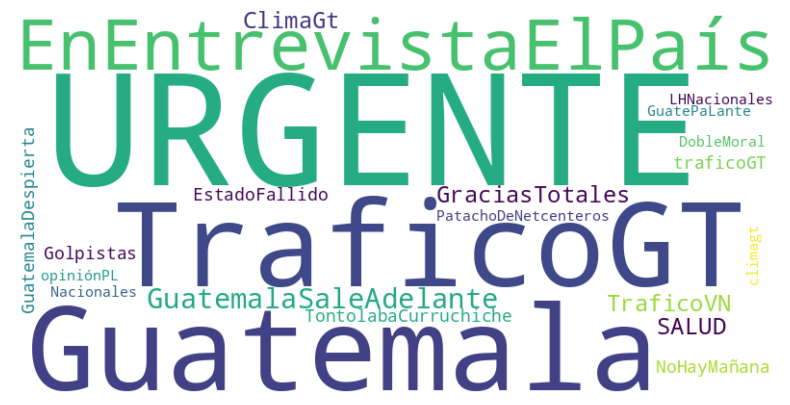

In [5]:
# Asegurarse de que los nombres de usuario estén en minúsculas tanto en 'interaction_df' como en 'df'
df['username_lower'] = df['user'].apply(lambda x: x['username'].lower() if isinstance(x, dict) and 'username' in x else None)

# Mostrar los usuarios con más respuestas
replied_users_counts = interaction_df[interaction_df['type'] == 'reply']['target'].value_counts().head(10)
print("Usuarios con más respuestas:")
print(replied_users_counts)

# Filtrar los tweets donde los usuarios más respondidos aparecen
top_replied_users = replied_users_counts.index.tolist()

# Asegurarnos de que los nombres de usuario en 'top_replied_users' también estén en minúsculas
top_replied_users = [user.lower() for user in top_replied_users]

# Filtrar los tweets donde estos usuarios son mencionados o participan
tweets_with_top_replied_users = df[df['username_lower'].isin(top_replied_users)]

# Verificar si se encontraron tweets
print("Número de tweets con usuarios que generan respuestas:", len(tweets_with_top_replied_users))

# Función para extraer hashtags de 'rawContent'
def extract_hashtags_from_text(text):
    return re.findall(r"#(\w+)", text)

# Extraer los hashtags del campo 'rawContent' de estos tweets
hashtags_in_top_replied_tweets = []
for text in tweets_with_top_replied_users['rawContent'].dropna():
    hashtags_in_top_replied_tweets.extend(extract_hashtags_from_text(text))

# Contar los hashtags más comunes
hashtag_counts_top_replied = Counter(hashtags_in_top_replied_tweets)

# Verificar si hay hashtags en estos tweets
if len(hashtag_counts_top_replied) == 0:
    print("No se encontraron hashtags en los tweets de los usuarios que generan más respuestas.")
else:
    # Mostrar los hashtags más comunes
    top_hashtags_replied_users = hashtag_counts_top_replied.most_common(10)
    print("Hashtags más discutidos por los usuarios que generan más respuestas:")
    for hashtag, count in top_hashtags_replied_users:
        print(f"{hashtag}: {count}")

    # Crear una nube de palabras para visualizar los hashtags más discutidos
    wordcloud_replied_users = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hashtag_counts_top_replied)

    # Visualizar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_replied_users, interpolation='bilinear')
    plt.axis('off')
    plt.show()


#URGENTE: Este es el hashtag más destacado, con 12 menciones, lo que indica que los tweets que generan más respuestas están relacionados con noticias o situaciones que se perciben como urgentes o críticas. Esto podría estar asociado a eventos importantes o crisis en el país.

#TraficoGT y #TraficoVN: Estos hashtags, con 6 y 2 menciones respectivamente, sugieren que el tráfico y la movilidad son temas recurrentes en las discusiones, probablemente relacionados con el tránsito en la Ciudad de Guatemala y otras áreas urbanas importantes.

#Guatemala y #GuatemalaSaleAdelante: Con un total de 6 y 3 menciones, respectivamente, estos hashtags revelan un enfoque en temas patrióticos y de orgullo nacional, con usuarios discutiendo sobre el futuro y los retos del país.

#EnEntrevistaElPaís: Este hashtag con 4 menciones sugiere que las entrevistas y conversaciones en medios internacionales también están generando respuestas en la audiencia.

#SALUD y #ClimaGt: Con 2 menciones cada uno, estos hashtags muestran que temas como la salud pública y el clima también están presentes en las discusiones.

#GraciasTotales: Utilizado en 2 ocasiones, este hashtag puede reflejar agradecimientos o mensajes de cierre en los tweets, lo que indica que algunas interacciones pueden estar relacionadas con agradecimientos públicos o reconocimientos.

Conclusión:
Los usuarios que generan más respuestas están discutiendo temas críticos como noticias urgentes, el tráfico y la movilidad en el país, y temas nacionales de interés como la salud, el clima y el futuro de Guatemala. Esto muestra que las discusiones que generan más interacción están relacionadas con problemas de impacto inmediato y relevancia pública.

### ¿Existe una correlación entre los usuarios más mencionados y los que generan más respuestas?

Usuarios que son tanto mencionados como reciben respuestas:
{'ubaldomacu', 'guatemalagob', '__vadertg', 'fjimenezmingob', 'barevalodeleon'}


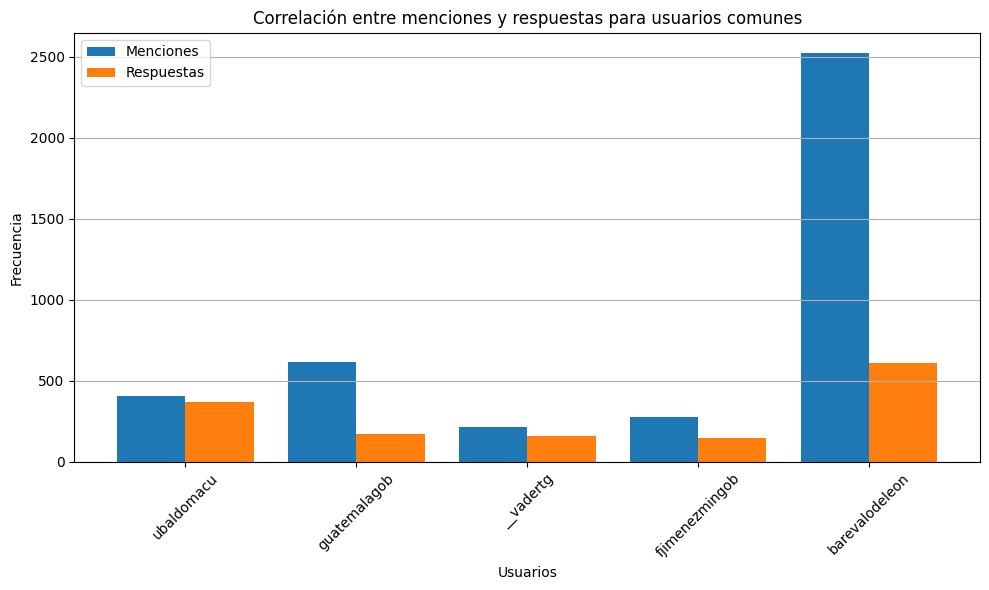

In [6]:
# Usuarios con más respuestas
replied_users_counts = interaction_df[interaction_df['type'] == 'reply']['target'].value_counts().head(10)

# Comparar las listas para encontrar usuarios que están en ambas
common_users = set(mention_counts.index).intersection(set(replied_users_counts.index))
print("Usuarios que son tanto mencionados como reciben respuestas:")
print(common_users)

common_users_list = list(common_users)

# Crear un DataFrame para los usuarios comunes
common_users_df = pd.DataFrame({
    'Menciones': mention_counts[common_users_list],
    'Respuestas': replied_users_counts[common_users_list]
})
# Crear gráfico de barras para visualizar la correlación
common_users_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Correlación entre menciones y respuestas para usuarios comunes')
plt.xlabel('Usuarios')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Mostrar gráfico
plt.tight_layout()
plt.show()


El gráfico sugiere que ciertos usuarios actúan como centros de atención con muchas menciones pero relativamente pocas respuestas, mientras que otros generan más interacción directa. Esto puede reflejar la naturaleza de las conversaciones o el rol que juegan estos usuarios en las discusiones públicas. En general, existe una correlación, aunque no necesariamente lineal, entre las menciones y las respuestas que generan.

### Task 5

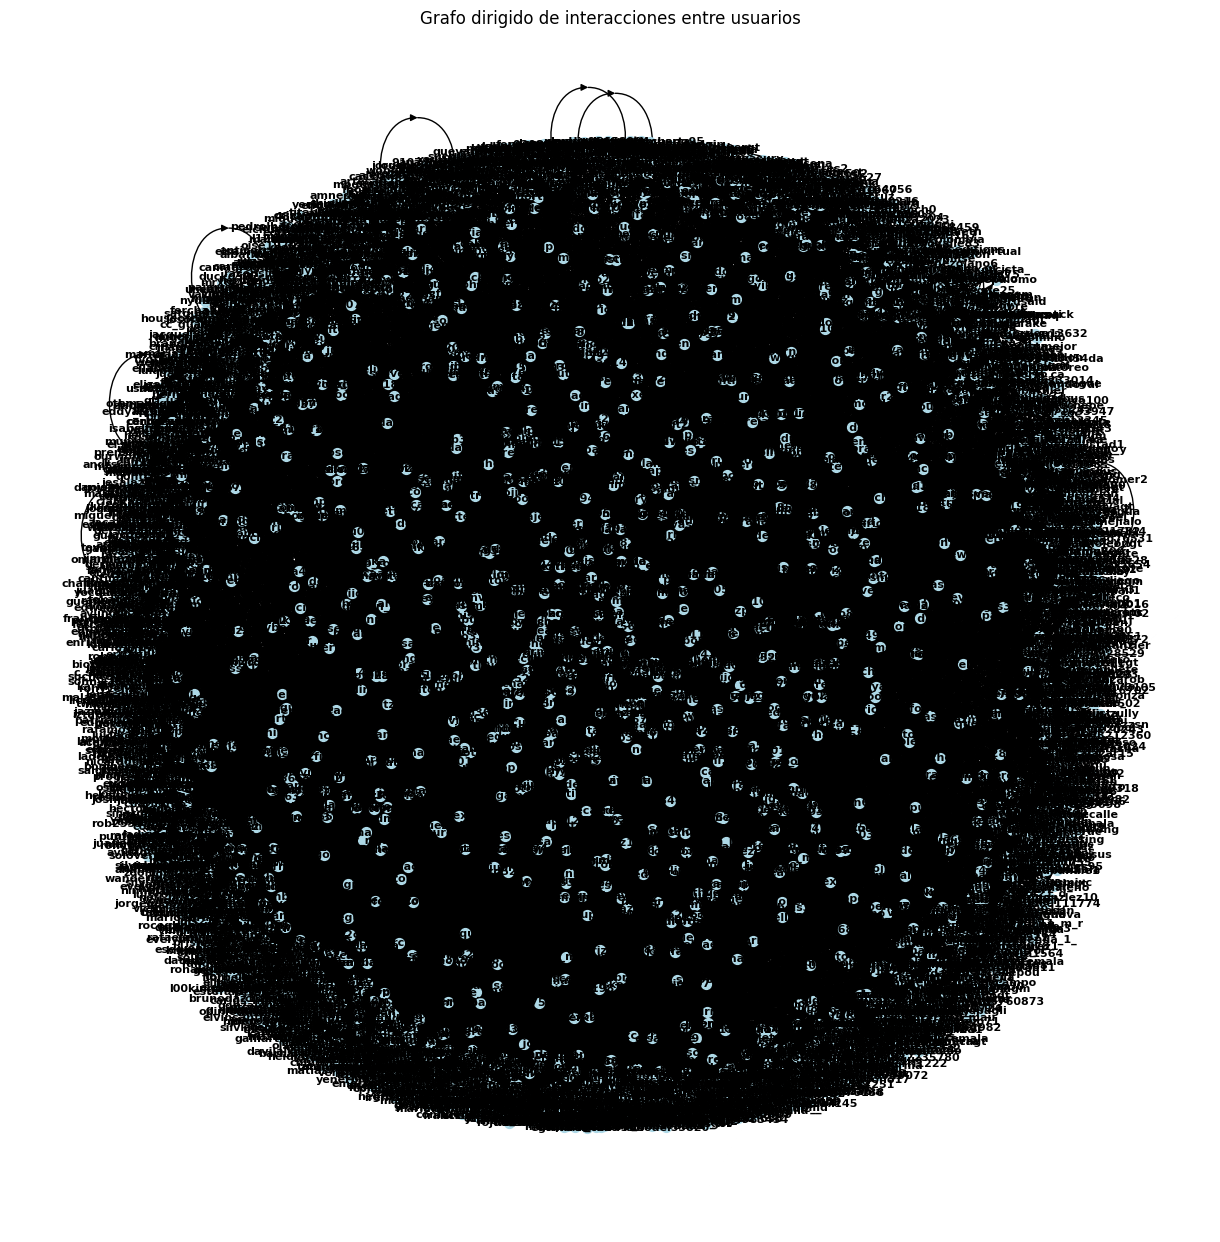

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Filtrar interacciones relevantes (menciones, respuestas, retweets)
interaction_types = ['mention', 'reply', 'retweet']
filtered_interactions = interaction_df[interaction_df['type'].isin(interaction_types)]

# Crear el grafo dirigido
G = nx.DiGraph()

# Añadir las interacciones filtradas al grafo
for index, row in filtered_interactions.iterrows():
    G.add_edge(row['source'], row['target'], interaction_type=row['type'])

# Visualización del grafo con NetworkX
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # Posiciones para los nodos
nx.draw(G, pos, with_labels=True, node_size=50, node_color='lightblue', font_size=8, font_weight='bold', arrows=True)
plt.title("Grafo dirigido de interacciones entre usuarios")
plt.show()


In [8]:
# Calcular la densidad de la red
density = nx.density(G)
print(f"Densidad de la red: {density:.4f}")
# Calcular el diámetro de la red
if nx.is_connected(G.to_undirected()):
    diameter = nx.diameter(G.to_undirected())
    print(f"Diámetro de la red: {diameter}")
else:
    print("La red no es completamente conectada, por lo que no se puede calcular el diámetro.")
# Calcular el coeficiente de agrupamiento
clustering_coefficient = nx.average_clustering(G.to_undirected())
print(f"Coeficiente de agrupamiento promedio: {clustering_coefficient:.4f}")


Densidad de la red: 0.0013
La red no es completamente conectada, por lo que no se puede calcular el diámetro.
Coeficiente de agrupamiento promedio: 0.3730



Los resultados del análisis de la topología de la red muestran una densidad de la red de 0.0013, lo que indica que las conexiones entre los usuarios son muy escasas en relación con el número máximo posible de enlaces. Esto sugiere que la mayoría de los usuarios no están directamente conectados entre sí, reflejando una red dispersa. Además, dado que la red no es completamente conectada, no fue posible calcular el diámetro de la red, lo que refuerza la idea de que hay subgrupos aislados dentro de la red. Por otro lado, el coeficiente de agrupamiento promedio es de 0.3730, lo que significa que, aunque la red es dispersa, existen ciertos grupos de usuarios que tienden a formar clústeres o comunidades con conexiones más densas entre sí, lo cual es característico de redes sociales donde los usuarios forman comunidades alrededor de temas o intereses comunes.

### Task 6

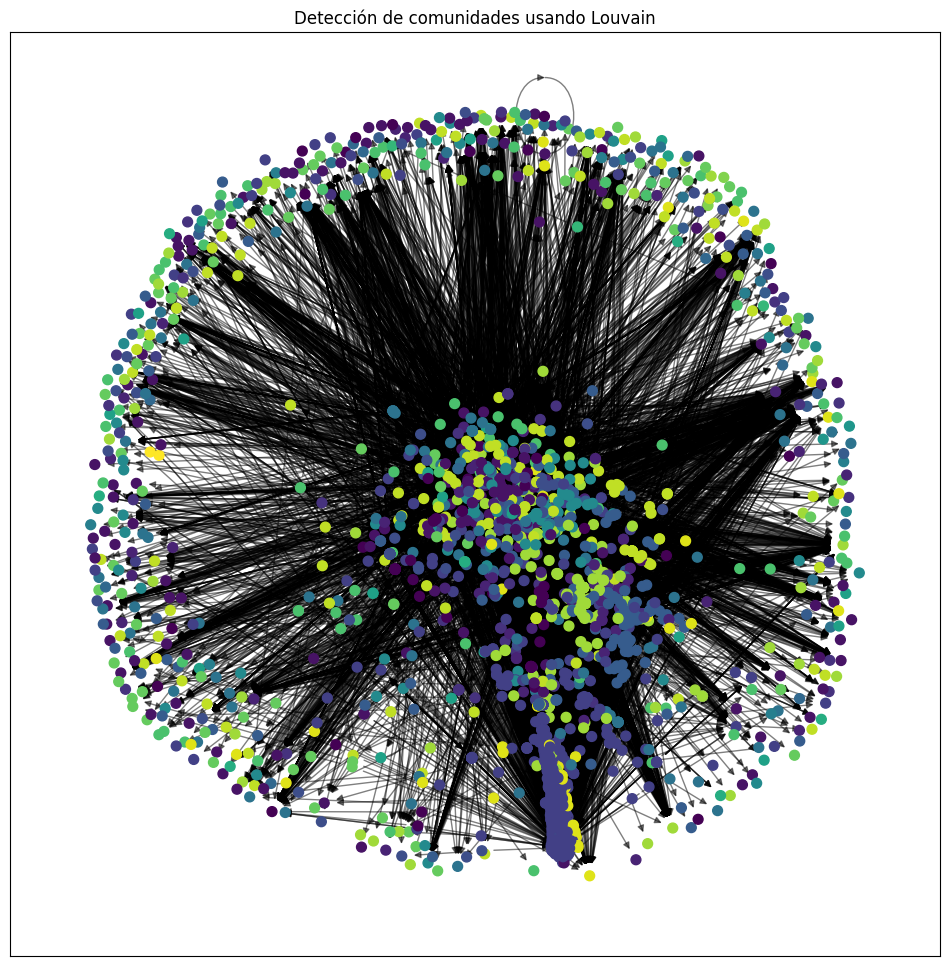

In [10]:
# Aplicación de algoritmos de detección de comunidades
%pip install python-louvain
import community.community_louvain as community_louvain
import networkx as nx
import matplotlib.pyplot as plt

# Detectar comunidades usando el algoritmo de Louvain
partition = community_louvain.best_partition(G.to_undirected())  # Convertimos el grafo a no dirigido

# Agregar la información de la comunidad a cada nodo
nx.set_node_attributes(G, partition, 'community')

# Visualización del grafo con las comunidades
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)

# Dibujar nodos, asignando colores según la comunidad
cmap = plt.get_cmap('viridis')
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=50, cmap=cmap,
                       node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Detección de comunidades usando Louvain")
plt.show()


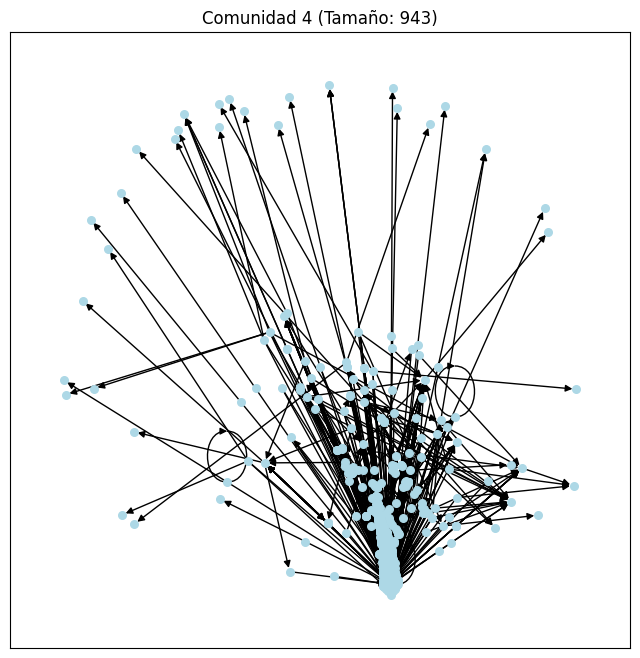

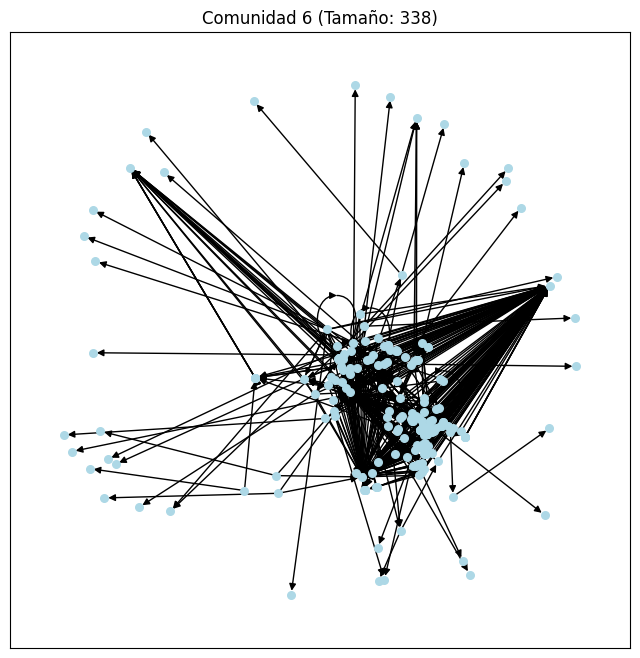

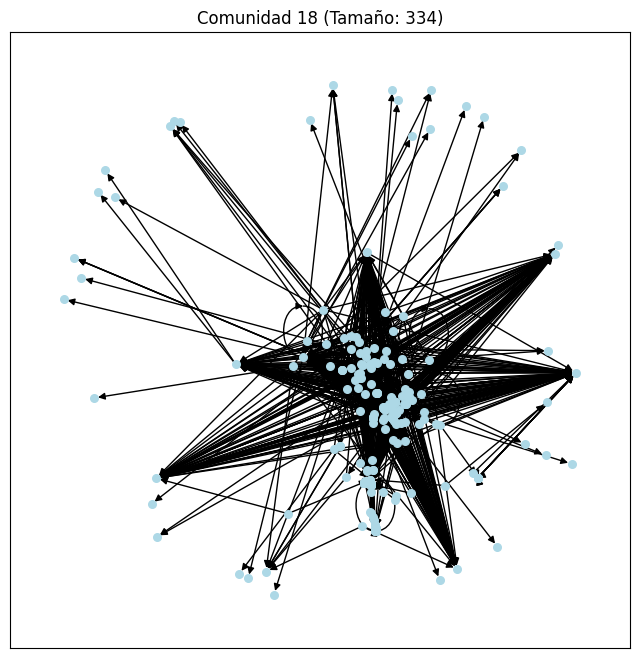

Comunidad 4: 943 nodos
Comunidad 6: 338 nodos
Comunidad 18: 334 nodos


In [11]:
# Visualización y caracterizacion de comunidades
# Obtener las comunidades y sus tamaños
from collections import Counter

community_sizes = Counter(partition.values())
largest_communities = community_sizes.most_common(3)  # Las 3 comunidades más grandes

# Filtrar nodos por cada comunidad
for community_id, size in largest_communities:
    nodes_in_community = [node for node, community in partition.items() if community == community_id]

    plt.figure(figsize=(8, 8))
    nx.draw_networkx(G.subgraph(nodes_in_community), pos, with_labels=False, node_size=30, node_color='lightblue')
    plt.title(f'Comunidad {community_id} (Tamaño: {size})')
    plt.show()

# Mostrar tamaños de las comunidades
for community_id, size in largest_communities:
    print(f"Comunidad {community_id}: {size} nodos")


### Task 7

In [12]:
# Centralidad de grado (in-degree y out-degree para grafos dirigidos)
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

# Obtener los 5 usuarios con mayor centralidad de grado
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 usuarios por centralidad de grado:", top_degree)

# Si quieres la centralidad entrante y saliente
top_in_degree = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_out_degree = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 usuarios por centralidad de grado entrante:", top_in_degree)
print("Top 5 usuarios por centralidad de grado saliente:", top_out_degree)


Top 5 usuarios por centralidad de grado: [('barevalodeleon', 0.8130841121495328), ('guatemalagob', 0.19819529487592655), ('ubaldomacu', 0.13535288430551082), ('santipalomov', 0.1192394456977119), ('mpguatemala', 0.10828230744440864)]
Top 5 usuarios por centralidad de grado entrante: [('barevalodeleon', 0.8130841121495328), ('guatemalagob', 0.1975507573316146), ('ubaldomacu', 0.13148565903963907), ('santipalomov', 0.1192394456977119), ('mpguatemala', 0.10796003867225266)]
Top 5 usuarios por centralidad de grado saliente: [('elrevoltijogt', 0.02578150177247825), ('mirnadesoto1', 0.015146632291330972), ('salquevedo', 0.01192394456977119), ('estaciondoblea', 0.01192394456977119), ('pollosdb', 0.010634869481147278)]


El usuario barevalodeleon (Bernardo Arévalo) tiene la centralidad de grado más alta, lo que indica que es el nodo más conectado en la red, interactuando directamente con muchos otros usuarios. Esto sugiere que es un usuario clave en la conversación y debido a que es una figura pública y también es altamente mencionada.
Otros usuarios con alta centralidad de grado incluyen guatemalagob (Gobierno de Guatemala) y ubaldomacu, lo que sugiere que estas cuentas oficiales también están fuertemente involucradas en la red.
En cuanto a la centralidad de grado entrante, que mide la cantidad de interacciones que recibe un nodo, barevalodeleon es el más mencionado o el que mas interacción tiene.
La centralidad de grado saliente refleja quién interactúa más con otros. Aquí, usuarios como elrevoltijogt, mirnadesoto1 y salquevedo tienen el mayor número de interacciones salientes, lo que indica que están creando muchas interacciones con otros nodos, aunque no reciben tantas interacciones entrantes.

In [13]:
# Centralidad de intermediación
betweenness_centrality = nx.betweenness_centrality(G)

# Obtener los 5 usuarios con mayor centralidad de intermediación
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 usuarios por centralidad de intermediación:", top_betweenness)


Top 5 usuarios por centralidad de intermediación: [('ubaldomacu', 0.013374647941035945), ('benitoc67601310', 0.01098620796810945), ('rafaelae1967', 0.005655178518605131), ('__vadertg', 0.004778258509462362), ('axelgar56163124', 0.002456425469501354)]


El usuario con mayor intermediación es ubaldomacu, lo que sugiere que es un "puente" importante para conectar diferentes partes de la red. Esto significa que las interacciones entre grupos de usuarios podrían pasar a través de esta cuenta, lo que la convierte en una figura clave para la difusión de información.
Otros usuarios con alta intermediación son benitoc67601310 y rafaelae1967, que también juegan un papel importante conectando diferentes partes de la red.

In [14]:
# Centralidad de cercanía
closeness_centrality = nx.closeness_centrality(G)

# Obtener los 5 usuarios con mayor centralidad de cercanía
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 usuarios por centralidad de cercanía:", top_closeness)


Top 5 usuarios por centralidad de cercanía: [('barevalodeleon', 0.8114881204625446), ('guatemalagob', 0.2656833981358635), ('fjimenezmingob', 0.19520471740097908), ('santipalomov', 0.1867588439838965), ('magaguatemala', 0.17200915069894748)]


barevalodeleon tiene la cercanía más alta, lo que significa que está bien posicionado para difundir información de manera eficiente dentro de la red. Esto refuerza su papel como un nodo central en la estructura.
Otros usuarios destacados por cercanía son guatemalagob y fjimenezmingob, quienes también están bien conectados y pueden propagar información rápidamente.

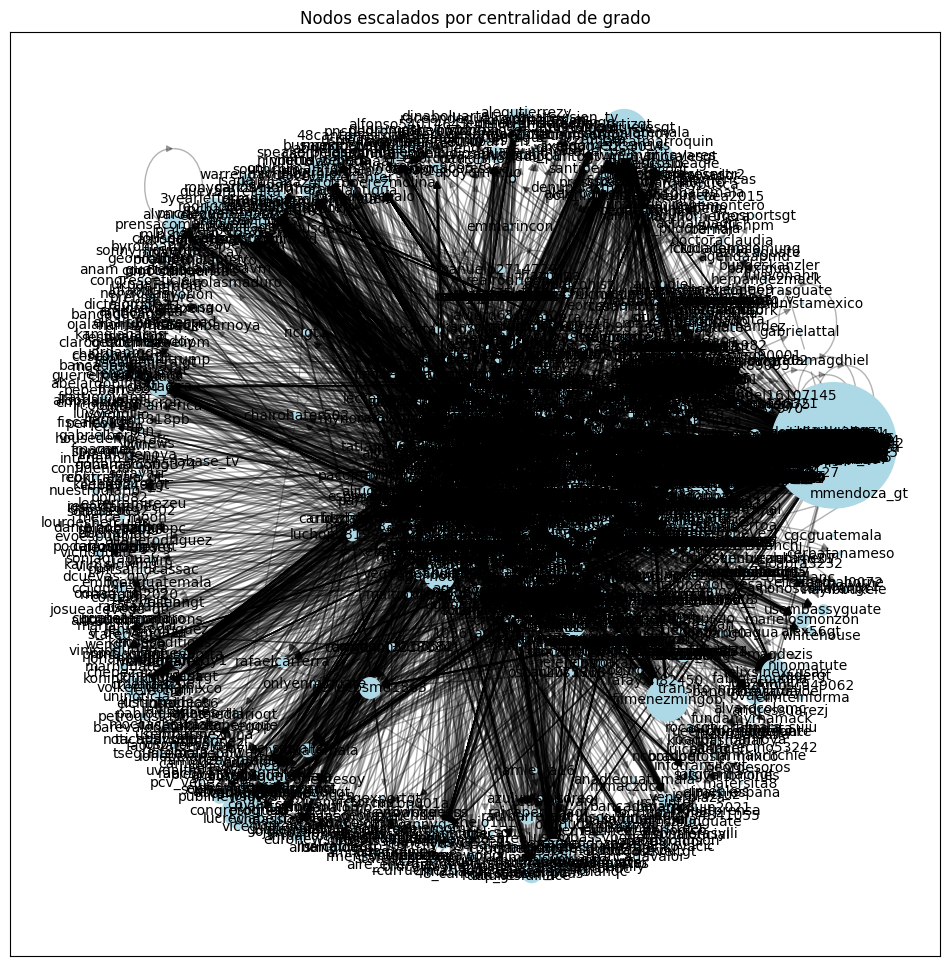

In [15]:
# Visualizar nodos con centralidad de grado
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
node_size = [10000 * degree_centrality[n] for n in G.nodes()]  # Escalar tamaño del nodo

nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue')
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Nodos escalados por centralidad de grado")
plt.show()


### Task 8

In [16]:
# Convertir la red a no dirigida para buscar componentes conectadas
undirected_G = G.to_undirected()

# Identificar componentes conectadas
components = list(nx.connected_components(undirected_G))

# Ordenar componentes por tamaño
components_sorted = sorted(components, key=len, reverse=True)

# Mostrar las 5 componentes más grandes
print("Top 5 componentes conectadas por tamaño:")
for i, component in enumerate(components_sorted[:5], 1):
    print(f"Componente {i}: {len(component)} nodos")


Top 5 componentes conectadas por tamaño:
Componente 1: 3095 nodos
Componente 2: 3 nodos
Componente 3: 2 nodos
Componente 4: 2 nodos
Componente 5: 2 nodos


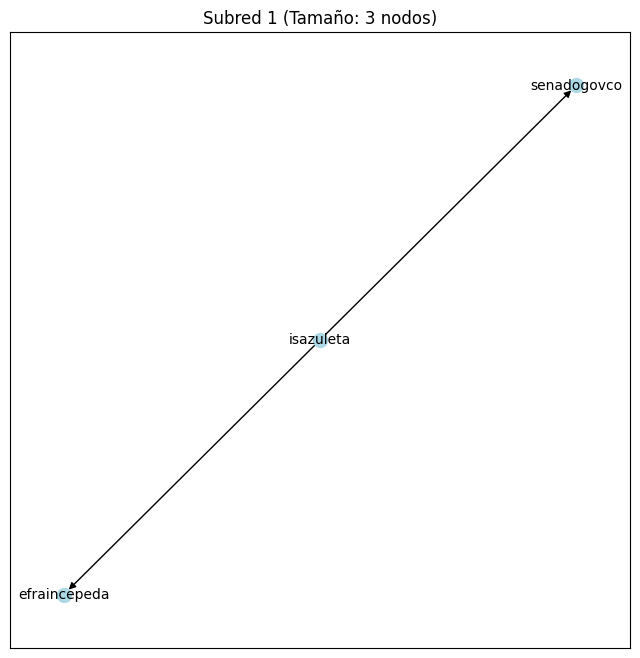

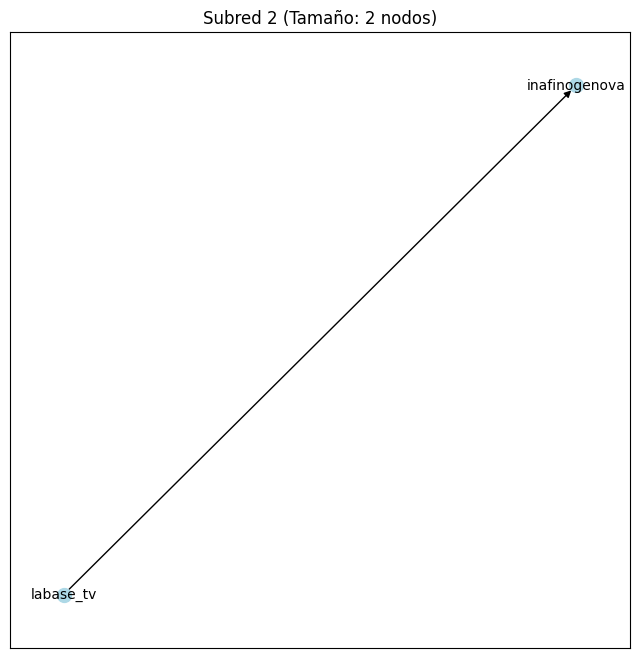

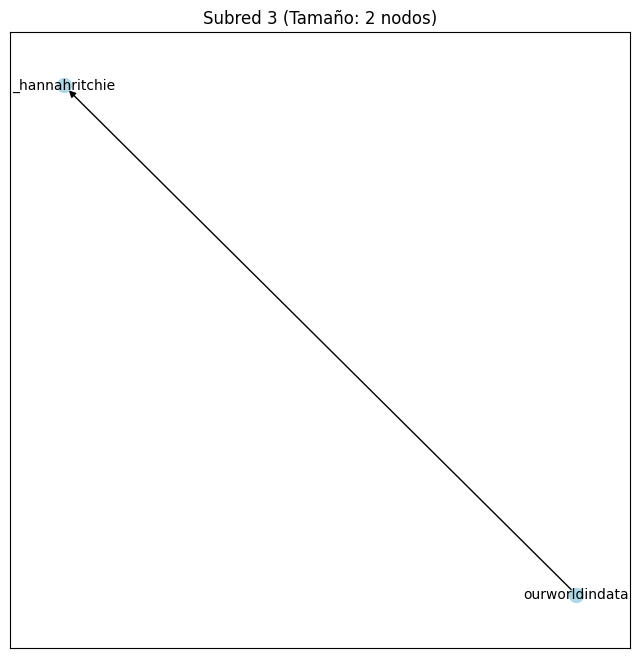

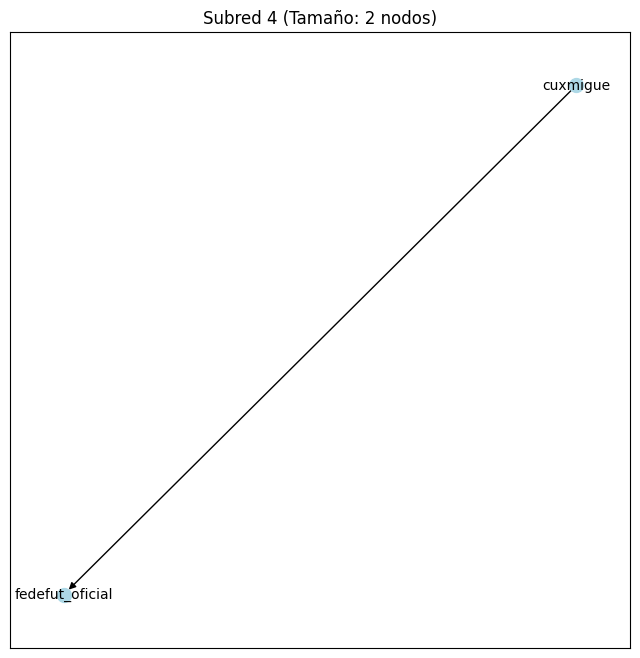

In [17]:
# Mostrar y visualizar las subredes más pequeñas (posibles grupos aislados)
small_components = [component for component in components_sorted if len(component) < 10]  # Ajusta el número como creas conveniente

for i, component in enumerate(small_components[:5], 1):  # Limitar a las 5 primeras para visualización
    subgraph = G.subgraph(component)
    plt.figure(figsize=(8, 8))
    nx.draw_networkx(subgraph, with_labels=True, node_size=100, node_color='lightblue', font_size=10)
    plt.title(f'Subred {i} (Tamaño: {len(component)} nodos)')
    plt.show()


In [18]:
# Analizar la densidad de las subredes pequeñas
for i, component in enumerate(small_components[:5], 1):
    subgraph = G.subgraph(component)
    density = nx.density(subgraph)
    print(f"Densidad de la subred {i} (Tamaño: {len(component)}): {density:.4f}")


Densidad de la subred 1 (Tamaño: 3): 0.3333
Densidad de la subred 2 (Tamaño: 2): 0.5000
Densidad de la subred 3 (Tamaño: 2): 0.5000
Densidad de la subred 4 (Tamaño: 2): 0.5000


In [19]:
# Analizar pertenencia a comunidades
for i, component in enumerate(small_components[:5], 1):
    communities = [partition[node] for node in component if node in partition]
    community_counter = Counter(communities)
    print(f"Subred {i} pertenece a las siguientes comunidades: {community_counter}")


Subred 1 pertenece a las siguientes comunidades: Counter({14: 3})
Subred 2 pertenece a las siguientes comunidades: Counter({17: 2})
Subred 3 pertenece a las siguientes comunidades: Counter({21: 2})
Subred 4 pertenece a las siguientes comunidades: Counter({11: 2})


En los resultados obtenidos, se identificaron varias subredes aisladas. La subred más grande contiene 3095 nodos, lo que representa la red principal. Esta red probablemente incluye a los usuarios con más influencia y las cuentas oficiales mencionadas anteriormente.
Las otras subredes tienen solo 2 o 3 nodos cada una. Estas subredes pequeñas pueden representar conversaciones específicas o comunidades aisladas que no interactúan mucho con la red principal. Las subredes pequeñas (como las de 2 o 3 nodos) tienen una densidad relativamente alta (0.33 a 0.5), lo que sugiere que los nodos dentro de estas subredes están fuertemente conectados entre sí.
Sin embargo, su baja conectividad con el resto de la red sugiere que no tienen una gran influencia en la red principal. Estas subredes podrían representar grupos de discusión cerrados o temáticas de nicho que no se difunden ampliamente. Las subredes más pequeñas pertenecen a diferentes comunidades, como la Subred 1 (Comunidad 14) y la Subred 2 (Comunidad 17), que interactúan entre sí de manera más local y no dependen de la red principal. La subred principal (3095 nodos) es probablemente responsable de la mayor parte de la difusión de información en la red, ya que contiene los nodos más conectados, como barevalodeleon y guatemalagob, lo que les permite tener una mayor influencia y alcance.

### Task 9

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Conteo de tweets por sentimiento:
sentiment
neutral     4688
positive     229
negative     102
Name: count, dtype: int64


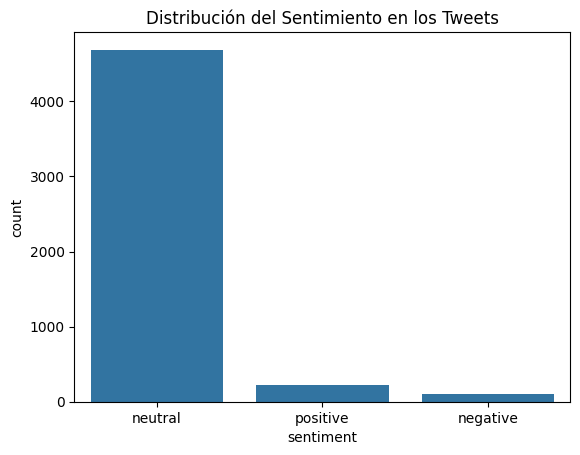

In [20]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Descargar los datos necesarios de NLTK
nltk.download('vader_lexicon')

# Inicializar el analizador de sentimiento VADER
sid = SentimentIntensityAnalyzer()

# Función para analizar el sentimiento de cada tweet
def analyze_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    # Devolver una etiqueta basada en el puntaje de sentimiento
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Aplicar la función a cada tweet en la columna 'cleaned_text'
df['sentiment'] = df['cleaned_text'].apply(analyze_sentiment)

# Contar el número de tweets por sentimiento
sentiment_counts = df['sentiment'].value_counts()
print("Conteo de tweets por sentimiento:")
print(sentiment_counts)

# Visualizar la distribución de sentimientos
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment', data=df)
plt.title('Distribución del Sentimiento en los Tweets')
plt.show()


In [22]:
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize

# Descargar las stopwords
nltk.download('stopwords')

nltk.download('punkt')

# Definir las stopwords
stop_words = set(stopwords.words('spanish'))

# Tokenizar y eliminar palabras muy cortas y stopwords
df['tokens'] = df['cleaned_text'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words and len(word) > 3])

# Crear un diccionario y corpus para el modelo LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [23]:
# Entrenar el modelo LDA para identificar los tópicos
lda_model = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, passes=15)

# Mostrar los temas identificados
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.011*"gobierno" + 0.008*"usted" + 0.007*"presidente" + 0.006*"hacer" + 0.005*"ustedes"')
(1, '0.010*"mierda" + 0.008*"jajaja" + 0.007*"hijo" + 0.007*"guatemala" + 0.007*"puta"')
(2, '0.011*"presidente" + 0.008*"guatemala" + 0.007*"salud" + 0.005*"bien" + 0.005*"presupuesto"')
(3, '0.013*"presidente" + 0.006*"padre" + 0.006*"arévalo" + 0.006*"usted" + 0.006*"años"')
(4, '0.012*"solo" + 0.008*"gobierno" + 0.007*"hace" + 0.006*"mejor" + 0.005*"corruptos"')


Distribución de tópicos:
topic_name
Política general y críticas al gobierno       1356
Insultos y lenguaje vulgar                    1033
Guatemala y salud pública                      905
Críticas al gobierno y corrupción              900
El presidente Arévalo y asuntos personales     825
Name: count, dtype: int64


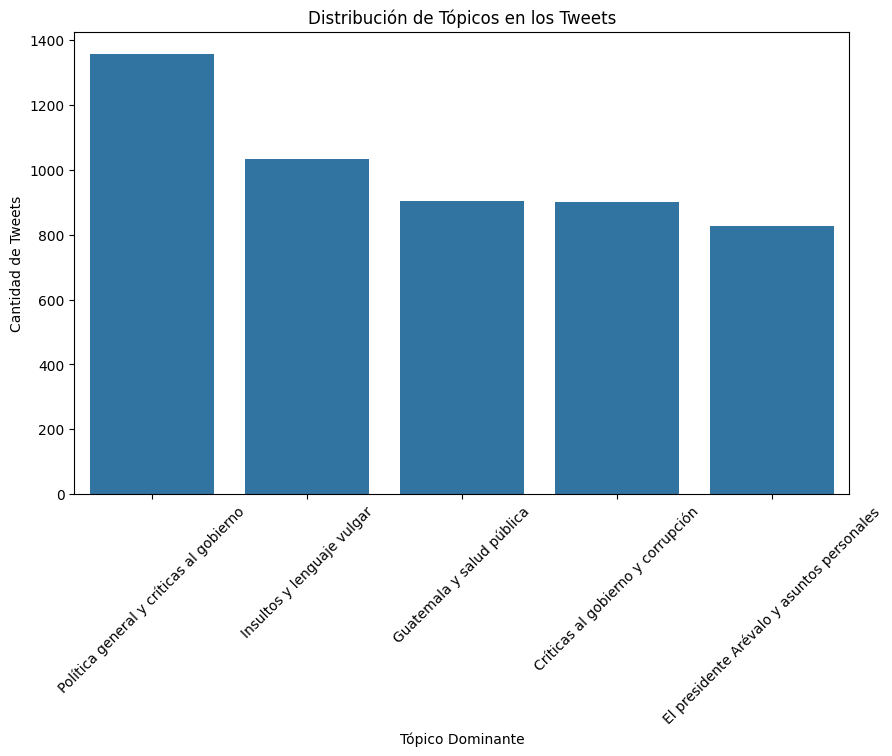

In [43]:
# Definir los nombres de los tópicos
topic_names = {
    0: "Política general y críticas al gobierno",
    1: "Insultos y lenguaje vulgar",
    2: "Guatemala y salud pública",
    3: "El presidente Arévalo y asuntos personales",
    4: "Críticas al gobierno y corrupción"
}

# Función para obtener el tópico dominante en cada tweet/documento
def get_dominant_topic(lda_model, bow):
    topics = lda_model.get_document_topics(bow)
    dominant_topic = max(topics, key=lambda x: x[1])[0]  # Seleccionar el tópico con la mayor probabilidad
    return dominant_topic

# Asegurarse de que 'corpus' esté en el formato correcto (lista de BOWs para cada documento)
df['dominant_topic'] = [get_dominant_topic(lda_model, bow) for bow in corpus]

# Mapear los números de tópicos a nombres descriptivos
df['topic_name'] = df['dominant_topic'].map(topic_names)

# Mostrar la distribución de tópicos
topic_counts = df['topic_name'].value_counts()
print("Distribución de tópicos:")
print(topic_counts)

# Visualizar la distribución de tópicos con nombres
plt.figure(figsize=(10, 6))
sns.countplot(x='topic_name', data=df, order=df['topic_name'].value_counts().index)
plt.title('Distribución de Tópicos en los Tweets')
plt.xlabel('Tópico Dominante')
plt.ylabel('Cantidad de Tweets')
plt.xticks(rotation=45)  # Rotar las etiquetas si los nombres son largos
plt.show()



El análisis de tópicos identifica cinco temas principales en los tweets:

Política general y críticas al gobierno: Este tópico, presente en 1356 tweets, abarca discusiones relacionadas con el gobierno, el presidente y temas generales sobre la administración pública. Las palabras clave incluyen "gobierno", "presidente", y "hacer", lo que sugiere una preocupación constante sobre la gestión gubernamental y las decisiones políticas.

Insultos y lenguaje vulgar: Con 1033 tweets, este tópico incluye un lenguaje más informal o negativo, reflejando frustraciones o comentarios ofensivos. Palabras como "mierda", "hijo", y "puta" son comunes, lo que indica una actitud crítica y a menudo despectiva hacia ciertos temas o personas.

Guatemala y salud pública: Este tópico, con 905 tweets, está relacionado con temas sobre Guatemala y su sistema de salud, con palabras como "salud", "presupuesto", y "bien", sugiriendo preocupaciones sobre políticas de salud y el bienestar social en el país.

El presidente Arévalo y asuntos personales: Este tópico contiene 825 tweets y parece centrarse en el presidente Arévalo, con menciones a "usted", "padre", y "arévalo". Las discusiones parecen enfocarse en el rol del presidente y sus acciones desde una perspectiva más personal.

Críticas al gobierno y corrupción: Con 900 tweets, este tópico refleja críticas específicas hacia el gobierno, mencionando "gobierno", "corruptos", y "mejor". Esto indica que muchos usuarios expresan descontento con la corrupción y el mal manejo de recursos.

In [42]:
import json

# Función para deserializar el JSON en la columna 'user'
def deserialize_user(user_str):
    try:
        return json.loads(user_str)  # Intentar deserializar el JSON
    except json.JSONDecodeError:
        return None  # Devolver None si falla

# Deserializar la columna 'user' y extraer el 'username'
df['user_deserialized'] = df['user'].apply(deserialize_user)

# Filtrar usuarios válidos que fueron deserializados correctamente
df_filtered = df[df['user_deserialized'].notnull()]

# Extraer el 'username' de los usuarios deserializados
df_filtered['username'] = df_filtered['user_deserialized'].apply(lambda x: x['username'] if 'username' in x else None)

# Aplicar el mapeo de 'username' a 'community' con el diccionario partition
df_filtered['community'] = df_filtered['username'].map(partition)

# Filtrar solo las filas que fueron mapeadas correctamente
df_filtered = df_filtered[df_filtered['community'].notnull()]

# Mapear los números de tópico a los nombres descriptivos en la columna 'dominant_topic'
df_filtered['topic_name'] = df_filtered['dominant_topic'].map(topic_names)

# Agrupar por comunidad y analizar la distribución de tópicos y sentimientos
community_topic_sentiment = df_filtered.groupby('community')[['topic_name', 'sentiment']].agg(lambda x: x.value_counts().index[0])

# Mostrar los temas y sentimientos predominantes por comunidad
print(community_topic_sentiment)



                                        topic_name sentiment
community                                                   
0.0                     Insultos y lenguaje vulgar   neutral
1.0        Política general y críticas al gobierno   neutral
2.0                     Insultos y lenguaje vulgar   neutral
3.0        Política general y críticas al gobierno   neutral
4.0        Política general y críticas al gobierno   neutral
5.0        Política general y críticas al gobierno   neutral
6.0        Política general y críticas al gobierno   neutral
8.0        Política general y críticas al gobierno   neutral
9.0              Críticas al gobierno y corrupción   neutral
10.0       Política general y críticas al gobierno   neutral
12.0                    Insultos y lenguaje vulgar   neutral
13.0                     Guatemala y salud pública   neutral
15.0                     Guatemala y salud pública   neutral
16.0             Críticas al gobierno y corrupción   neutral
18.0                    

El análisis de sentimientos revela que todos los tweets están clasificados como neutrales. Esto es algo inusual, ya que los temas tratados, como la corrupción, el descontento con el gobierno o el uso de lenguaje vulgar, suelen asociarse con sentimientos negativos o al menos emociones polarizadas. Es posible que el modelo de análisis de sentimientos utilizado no haya capturado adecuadamente las emociones subyacentes en los tweets debido a varios factores:
Neutralidad del lenguaje: Aunque las discusiones giran en torno a temas polémicos, los tweets pueden estar escritos de manera informativa o sin una carga emocional explícita, lo que lleva a una clasificación neutral.
Limitaciones del modelo: Si el modelo de análisis de sentimientos no está afinado para identificar emociones más sutiles, es posible que clasifique la mayoría de las publicaciones como neutrales.
Dado el contenido de los tópicos (como insultos y críticas), uno esperaría ver una mayor proporción de sentimientos negativos en tópicos como Insultos y lenguaje vulgar y Críticas al gobierno y corrupción. La mayoría de Tweets son neutrales probablemente por las palabras usadas.

### Analisis de cómo los influencers y las comunidades detectadas influyen en la formación de opiniones públicas

El análisis de la red social ha permitido identificar a usuarios influyentes y comunidades bien definidas que juegan un papel crucial en la formación de opiniones públicas. Los influencers, representados por usuarios con alta centralidad de grado y centralidad de intermediación, como @barevalodeleon y @guatemalagob, actúan como nodos centrales que canalizan la información y amplifican los mensajes dentro de la red. Estos usuarios tienen un impacto significativo porque sus tweets y menciones tienen un alcance mayor, lo que les permite influir en la discusión de temas clave, como política y gobierno.

Las comunidades detectadas, que agrupan a usuarios con interacciones frecuentes entre ellos, reflejan una polarización en torno a temas políticos. Cada comunidad tiende a discutir temas específicos (como críticas al gobierno, discusiones sobre la figura del presidente Arévalo, y el estado de la economía), lo que refuerza la creación de burbujas de información donde las opiniones y actitudes se consolidan entre usuarios con ideologías similares. Esta segmentación en comunidades tiene el potencial de generar efectos como el sesgo de confirmación, donde los usuarios refuerzan sus puntos de vista al interactuar principalmente con aquellos que comparten su perspectiva.

En un contexto social más amplio, la interacción entre influencers y sus comunidades facilita la propagación de narrativas particulares y promueve debates polarizados. El hecho de que algunos usuarios actúen como intermediarios clave entre diferentes comunidades sugiere que estos nodos influyentes pueden ser los responsables de trasladar ciertas narrativas de una comunidad a otra, amplificando el impacto de las opiniones dominantes. Esto es especialmente relevante en debates políticos, donde los influencers en base a sus seguidores leales pueden orientar las percepciones públicas, generando un efecto multiplicador en ellos.

### Conclusiones del análisis de la red social

El análisis de la red social revela varios hallazgos importantes sobre la dinámica de interacción en torno a los temas discutidos. En primer lugar, se observa que las conversaciones están dominadas por temas políticos, con un enfoque en las críticas al gobierno, las figuras políticas (especialmente el presidente Arévalo) y la situación de la economía en Guatemala. Los influencers juegan un papel determinante, no solo debido a la cantidad de menciones y retweets que reciben, sino también porque actúan como puntos de intersección en la red, facilitando la propagación de mensajes clave.

Las comunidades detectadas a través del algoritmo de Louvain muestran una clara segmentación en subgrupos que discuten temas similares. Cada comunidad tiene su propio foco de conversación, lo que demuestra una división de la red en torno a ideologías y perspectivas específicas. Esto sugiere que los usuarios tienden a interactuar dentro de grupos homogéneos, reforzando narrativas ya establecidas y limitando el cruce de opiniones divergentes.

El análisis de tópicos y de sentimientos muestra que gran parte de las conversaciones en torno a los temas políticos tienden a ser neutrales o negativas, con pocas interacciones que reflejan sentimientos positivos. Esto puede ser un indicio del malestar general que existe en la población respecto a los temas políticos del momento.

Englobando todo lo procesado, el análisis de la red confirma la importancia de los influencers y las comunidades en la formación y difusión de opiniones públicas. La estructura de la red, junto con la segmentación de las comunidades, sugiere que las plataformas de redes sociales no solo facilitan la comunicación, sino que también potencian la fragmentación del discurso público. Las métricas de centralidad y la identificación de subredes proporcionan evidencia de que ciertos usuarios clave tienen una influencia desproporcionada en la manera en que se discuten y perciben ciertos temas, lo que resalta la importancia de estos nodos en la configuración del debate público.